In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model

In [2]:
def load_data(filename, inputs_variables_names=['Economy..GDP.per.Capita.', 'Freedom'],
              output_variable_name='Happiness.Score'):
    data = []
    data_names = []
    with open(filename) as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                data_names = row
            else:
                data.append(row)
            line_count += 1

    selected_variables_index = [data_names.index(variable) for variable in inputs_variables_names]
    inputs = []
    for var in selected_variables_index:
        inputs.append([data[index][var] for index in range(len(data))])

    output_selected_index = data_names.index(output_variable_name)
    outputs = [data[index][output_selected_index] for index in range(len(data))]

    return inputs, outputs

In [3]:
def plot_histogram(x, name):
    plt.hist(x, 10)
    plt.title('Histogram of ' + name)
    plt.show()

def plot(ins, outs):
    print(ins[0][:5])
    print(ins[1][:5])
    print(outs[:5])

    plot_histogram(ins[0], 'GDP per capita')
    plot_histogram(ins[1], 'Freedom')
    plot_histogram(outs, 'Happiness')

    plt.plot(ins[0], outs, 'ro')
    plt.xlabel('GDP capita')
    plt.ylabel('Happiness')
    plt.show()

    plt.plot(ins[1], outs, 'ro')
    plt.xlabel('Freedom')
    plt.ylabel('Happiness')
    plt.show()

In [4]:
def generate_training_test(ins, outs):
    np.random.seed(5)
    indexes = [i for i in range(len(outs))]
    train_sample = np.random.choice(indexes, int(0.8 * len(outs)), replace=False)
    validation_sample = [i for i in indexes if i not in train_sample]

    train_inputs = [[float(ins[0][index]) for index in train_sample], [float(ins[1][index]) for index in train_sample]]
    train_output = [float(outs[index]) for index in train_sample]

    validation_inputs = [[float(ins[0][index]) for index in validation_sample], [float(ins[1][index]) for index in validation_sample]]
    validation_output = [float(outs[index]) for index in validation_sample]

    return train_inputs, train_output, validation_inputs, validation_output

In [5]:
# by tool
def linear_regression_by_tool(train_inputs, train_output, validation_inputs, validation_output):
    sklearn_data = [(float(e1), float(e2)) for e1, e2 in zip(train_inputs[0], train_inputs[1])]
    regressor = linear_model.LinearRegression()
    regressor.fit(sklearn_data, train_output)

    w0, w1, w2 = regressor.intercept_, regressor.coef_[0], regressor.coef_[1]
    print('the learnt model (tool): f(x) = ', w0, ' + ', w1, ' * x1 + ', w2, ' * x2')

    arr = [[float(e1), float(e2)] for e1, e2 in zip(validation_inputs[0], validation_inputs[1])]

    computed_validation_output = regressor.predict(arr)

    from sklearn.metrics import mean_squared_error

    error = mean_squared_error(validation_output, computed_validation_output)
    print("Prediction error (tool): ", error)

In [6]:
# matrix operations
def get_matrix_minor(matrix, i, j):
    return [row[:j] + row[j + 1:] for row in (matrix[:i] + matrix[i + 1:])]


def get_matrix_determinant(matrix):
    if len(matrix) == 2:
        return matrix[0][0] * matrix[1][1] - matrix[0][1] * matrix[1][0]
    determinant = 0
    for column in range(len(matrix)):
        determinant += ((-1) ** column) * matrix[0][column] * get_matrix_determinant(
            get_matrix_minor(matrix, 0, column))
    return determinant


def transpose_matrix(matrix):
    return list(map(list, zip(*matrix)))


def get_matrix_inverse(matrix):  # X* / determinant; X* = XT * (-1) ** (r + c)
    determinant = get_matrix_determinant(matrix)
    if len(matrix) == 2:
        return [[matrix[1][1] / determinant, -1 * matrix[0][1] / determinant],
                [-1 * matrix[1][0] / determinant, matrix[0][0] / determinant]]
    matrixX = []
    for row in range(len(matrix)):
        matrixX_row = []
        for column in range(len(matrix)):
            minor = get_matrix_minor(matrix, row, column)
            matrixX_row.append(((-1) ** (row + column)) * get_matrix_determinant(minor))
        matrixX.append(matrixX_row)
    matrixX = transpose_matrix(matrixX)
    for row in range(len(matrixX)):
        for column in range(len(matrixX)):
            matrixX[row][column] = matrixX[row][column] / determinant
    return matrixX


In [7]:
def calculate_y(w, validation_output):
    y = []
    for f1, f2 in zip(*validation_output):
        y.append(w[0] + f1 * w[1] + f2 * w[2])
    return y

def test(computed_output, validation_output):
    error = 0.0
    for t1, t2 in zip(computed_output, validation_output):
        error += (t1 - t2) ** 2
    error = error / len(validation_output)
    print('Prediction error: ', error)

def linear_regression_by_me(train_inputs, train_output, validation_inputs, validation_output): # (XT * X) ** (-1) * (XT) * Y
    XT = [[1] * len(train_inputs[0])] + train_inputs
    XTX = []
    for row1 in XT:
        line = []
        for row2 in XT:
            line.append(sum([x * y for x, y in zip(row1, row2)]))
        XTX.append(line)
    XTX_inverse = get_matrix_inverse(XTX)
    XTX_inverse_XT = []
    for row in XTX_inverse:
        line = []
        for row1 in transpose_matrix(XT):
            line.append(sum([x * y for x, y in zip(row, row1)]))
        XTX_inverse_XT.append(line)
    XTX_inverse_XTY = []
    for row in XTX_inverse_XT:
        XTX_inverse_XTY.append(sum([x * y for x, y in zip(row, train_output)]))

    w0, w1, w2 = XTX_inverse_XTY[0], XTX_inverse_XTY[1], XTX_inverse_XTY[2]
    print('the learnt model (me <3): f(x) = ', w0 , ' + ', w1, ' * x1 + ', w2, ' * x2')

    test(calculate_y(XTX_inverse_XTY, validation_inputs), validation_output)

In [8]:
def plot_data_3d(inputs, outputs, input_variable_name ="GPD", input_variable_name2 ="Freedom",
                 output_variable_name ="Happiness"):
    plt.style.use('default')
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    trainInputs, trainOutputs, validationInputs, validationOutputs = generate_training_test(inputs, outputs)
    ax.scatter(trainInputs[0], trainInputs[1], trainOutputs, c='r', marker='o', label='Train data')
    ax.scatter(validationInputs[0], validationInputs[1], validationOutputs, c='g', marker='^', label='Validation data')
    ax.set_xlabel(input_variable_name)
    ax.set_ylabel(input_variable_name2)
    ax.set_zlabel(output_variable_name)
    plt.legend(loc='upper right')
    plt.show()

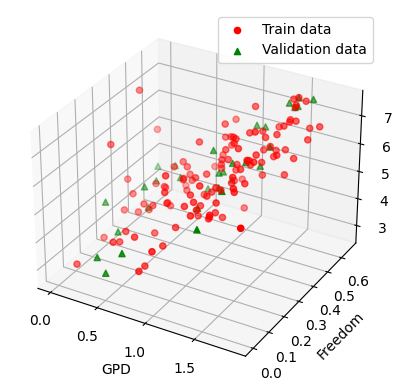

the learnt model (tool): f(x) =  2.7629923406916572  +  1.6238620005617537  * x1 +  2.5193430719396464  * x2
Prediction error (tool):  0.22615902602316174
the learnt model (me <3): f(x) =  2.7629923406916337  +  1.623862000561737  * x1 +  2.5193430719396326  * x2
Prediction error:  0.22615902602317275


In [9]:
file_v1 = 'data/v1_world-happiness-report-2017.csv'
file_v2 = 'data/v2_world-happiness-report-2017.csv'
file_v3 = 'data/v3_world-happiness-report-2017.csv'
inputs, output = load_data(file_v3)

plot_data_3d(inputs, output)

train_inputs, train_outputs, validate_inputs, validate_outputs = generate_training_test(inputs, output)

linear_regression_by_tool(train_inputs, train_outputs, validate_inputs, validate_outputs)
linear_regression_by_me(train_inputs, train_outputs, validate_inputs, validate_outputs)

In [10]:
inputs, output = load_data(file_v3, ['Economy..GDP.per.Capita.'], 'Freedom')
inputs = inputs[0]
real_data = []
real_output = []
prediction = []
for i in range(len(output)):
    if output[i] != '0':
        real_data.append(inputs[i])
        real_output.append(output[i])
    else:
        prediction.append(inputs[i])

regression1 = linear_model.LinearRegression()

regression1.fit([[float(x)] for x in real_data], real_output)

arr = [[float(x)] for x in prediction]
computed_output = regression1.predict(arr)

print([float(x) for x in prediction])
print(computed_output)


[1.870765686, 0.996192753, 0.85842818, 0.511135876]
[0.51618894 0.41473336 0.39875186 0.35846392]
